MOMENTUM ANALYSIS FOR SQUID INK

LOAD DATA

In [68]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
import warnings

# Ignore future warnings from statsmodels
warnings.simplefilter(action='ignore', category=FutureWarning)

# --- 1. Data Loading ---


HISTORICAL_DATA_DIR = 'C:/Users/Admin/Downloads/round-1-island-data-bottle/round-1-island-data-bottle' 
ROUND_1_PRODUCTS = ["KELP", "RAINFOREST_RESIN", "SQUID_INK"]

def load_historical_data_day(directory_path, day):
    """Loads prices and trades for a specific day."""
    day_data = {}
    day_str = str(day)
    prices_pattern = os.path.join(directory_path, f'prices_round_1_day_{day_str}.csv')
    trades_pattern = os.path.join(directory_path, f'trades_round_1_day_{day_str}.csv')

    price_files = glob.glob(prices_pattern)
    trade_files = glob.glob(trades_pattern)

    if price_files:
        try:
            df_prices = pd.read_csv(price_files[0], sep=';')
            df_prices['day'] = day
            day_data['prices'] = df_prices
            print(f"  Loaded prices for day {day} from {os.path.basename(price_files[0])}")
        except Exception as e:
            print(f"  Error loading prices file for day {day} ({os.path.basename(price_files[0])}): {e}")
    else:
        print(f"  Warning: Prices file not found for day {day}")

    if trade_files:
        try:
            df_trades = pd.read_csv(trade_files[0], sep=';')
            df_trades['day'] = day
            day_data['trades'] = df_trades
            print(f"  Loaded trades for day {day} from {os.path.basename(trade_files[0])}")
        except Exception as e:
            print(f"  Error loading trades file for day {day} ({os.path.basename(trade_files[0])}): {e}")
    else:
        print(f"  Warning: Trades file not found for day {day}")

    return day_data

# Load data for all Round 1 days
all_prices = []
all_trades = []
days = [-2, -1, 0]

print(f"Loading data from: {HISTORICAL_DATA_DIR}")
if not os.path.isdir(HISTORICAL_DATA_DIR):
    print(f"Error: Directory not found: {HISTORICAL_DATA_DIR}")
    # You might want to stop execution here or handle this error appropriately
else:
    for day in days:
        day_data = load_historical_data_day(HISTORICAL_DATA_DIR, day)
        if 'prices' in day_data:
            all_prices.append(day_data['prices'])
        if 'trades' in day_data:
            all_trades.append(day_data['trades'])

# Combine dataframes
prices_df = pd.concat(all_prices, ignore_index=True) if all_prices else pd.DataFrame()
trades_df = pd.concat(all_trades, ignore_index=True) if all_trades else pd.DataFrame()

print("\nFinished loading data.")
if not prices_df.empty:
    print(f"Total price rows: {len(prices_df)}")
else:
    print("Price data is empty!")
if not trades_df.empty:
    print(f"Total trade rows: {len(trades_df)}")
else:
    print("Trade data is empty!")

Loading data from: C:/Users/Admin/Downloads/round-1-island-data-bottle/round-1-island-data-bottle
  Loaded prices for day -2 from prices_round_1_day_-2.csv
  Loaded trades for day -2 from trades_round_1_day_-2.csv
  Loaded prices for day -1 from prices_round_1_day_-1.csv
  Loaded trades for day -1 from trades_round_1_day_-1.csv
  Loaded prices for day 0 from prices_round_1_day_0.csv
  Loaded trades for day 0 from trades_round_1_day_0.csv

Finished loading data.
Total price rows: 90000
Total trade rows: 24886


MID PRICE CALCULATION


In [69]:
def calculate_mid_price(row):
    """Calculates mid-price using best bid and ask."""
    best_bid = row.get('bid_price_1')
    best_ask = row.get('ask_price_1')

    if pd.notna(best_bid) and pd.notna(best_ask):
        return (best_bid + best_ask) / 2.0
    elif pd.notna(best_bid):
        return best_bid # Use bid if ask is missing
    elif pd.notna(best_ask):
        return best_ask # Use ask if bid is missing
    else:
        # Attempt to use level 2 or 3 if level 1 is missing
        best_bid_2 = row.get('bid_price_2')
        best_ask_2 = row.get('ask_price_2')
        if pd.notna(best_bid_2) and pd.notna(best_ask_2):
             return (best_bid_2 + best_ask_2) / 2.0
        # Add more fallbacks if needed (e.g., level 3, last trade price)
        return np.nan # Return NaN if no valid price found

if not prices_df.empty:
    prices_df['mid_price'] = prices_df.apply(calculate_mid_price, axis=1)
    # Forward fill missing mid-prices - check if this is appropriate for momentum analysis
    # prices_df['mid_price'] = prices_df['mid_price'].ffill()
    print("\nMid-price calculated.")
    print(prices_df[['product', 'timestamp', 'bid_price_1', 'ask_price_1', 'mid_price']].head())
else:
    print("\nCannot calculate mid-price, prices_df is empty.")


Mid-price calculated.
            product  timestamp  bid_price_1  ask_price_1  mid_price
0  RAINFOREST_RESIN          0         9996        10004    10000.0
1              KELP          0         1998         2002     2000.0
2         SQUID_INK          0         1998         2002     2000.0
3         SQUID_INK        100         1999         2001     2000.0
4  RAINFOREST_RESIN        100        10000        10005    10002.5


FILTER DATA AND CALCULATE RETURNS

In [70]:
PRODUCT_TO_ANALYZE = "SQUID_INK"

if not prices_df.empty:
    product_prices = prices_df[prices_df['product'] == PRODUCT_TO_ANALYZE].copy()
    product_prices = product_prices.sort_values(by=['day', 'timestamp']).reset_index(drop=True)

    if not product_prices.empty:
        # Calculate log returns
        product_prices['log_return'] = np.log(product_prices['mid_price'] / product_prices['mid_price'].shift(1))*100

        # Handle potential NaNs created by shift and log(0) or log(negative) if mid_price issues exist
        product_prices.dropna(subset=['log_return'], inplace=True)
        product_prices = product_prices[np.isfinite(product_prices['log_return'])] # Remove inf/-inf

        print(f"\nFiltered for {PRODUCT_TO_ANALYZE} and calculated log returns.")
        print(product_prices[['timestamp', 'mid_price', 'log_return']].head())
        print(f"Number of valid returns for {PRODUCT_TO_ANALYZE}: {len(product_prices)}")
    else:
        print(f"\nNo price data found for {PRODUCT_TO_ANALYZE}.")
else:
    print("\nCannot filter data, prices_df is empty.")
    product_prices = pd.DataFrame() # Ensure it's an empty DF




Filtered for SQUID_INK and calculated log returns.
   timestamp  mid_price  log_return
1        100     2000.0    0.000000
2        200     1998.5   -0.075028
3        300     1998.5    0.000000
4        400     1998.0   -0.025022
5        500     1999.5    0.075047
Number of valid returns for SQUID_INK: 29999


SIGNIFICANCE OF MEAN RETURN

In [71]:
if not product_prices.empty and 'log_return' in product_prices.columns and len(product_prices['log_return']) > 1:
    returns = product_prices['log_return']
    t_stat, p_value = stats.ttest_1samp(returns, 0)

    print(f"\n--- Mean Return Significance ({PRODUCT_TO_ANALYZE}) ---")
    print(f"Mean Log Return: {returns.mean():.6f}")
    print(f"T-statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print(f"The mean log return is statistically significantly different from zero (p < {alpha}).")
    else:
        print(f"The mean log return is NOT statistically significantly different from zero (p >= {alpha}).")
else:
    print(f"\nCould not perform significance test for {PRODUCT_TO_ANALYZE} (not enough data).")




--- Mean Return Significance (SQUID_INK) ---
Mean Log Return: -0.000279
T-statistic: -0.5287
P-value: 0.5970
The mean log return is NOT statistically significantly different from zero (p >= 0.05).


AUTOCORRELATION



--- Autocorrelation Analysis (SQUID_INK) ---


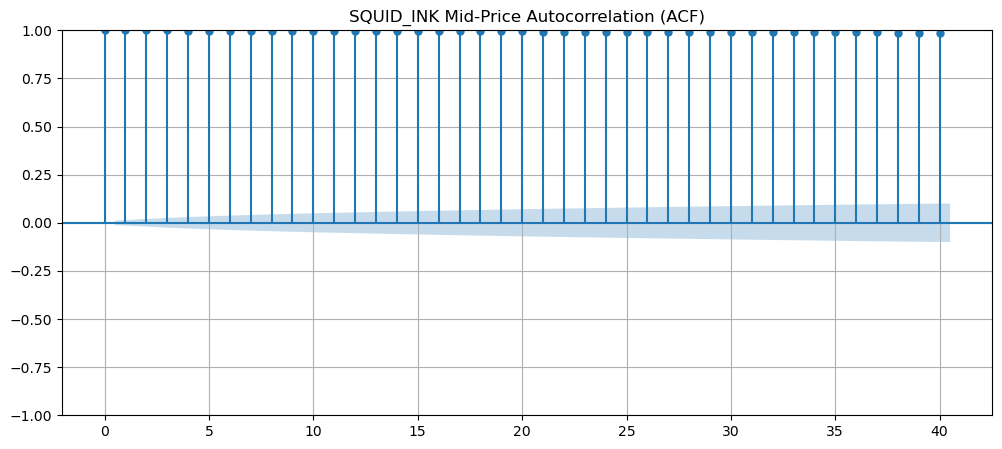

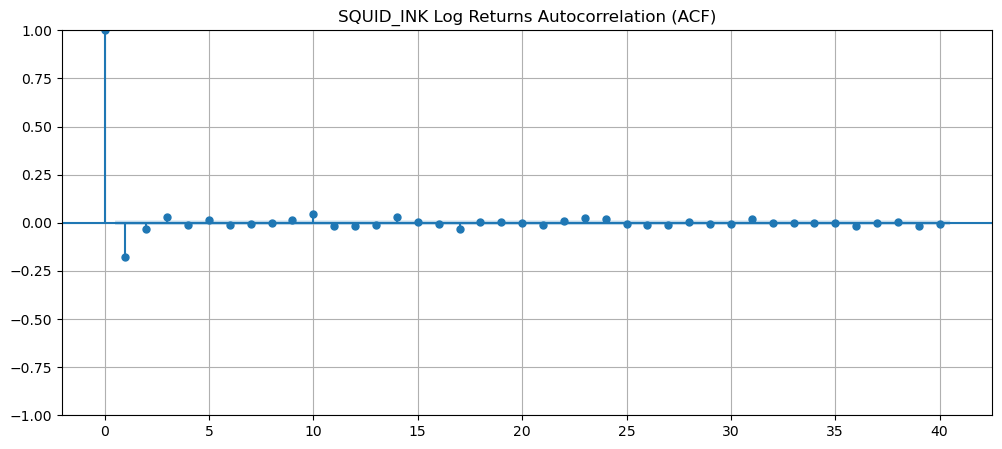

In [72]:
if not product_prices.empty and len(product_prices) > 1:
    print(f"\n--- Autocorrelation Analysis ({PRODUCT_TO_ANALYZE}) ---")

    # ACF for Prices
    fig_price_acf, ax_price_acf = plt.subplots(figsize=(12, 5))
    plot_acf(product_prices['mid_price'].dropna(), ax=ax_price_acf, lags=40, title=f'{PRODUCT_TO_ANALYZE} Mid-Price Autocorrelation (ACF)')
    ax_price_acf.grid(True)
    plt.show()

    # ACF for Log Returns
    if 'log_return' in product_prices.columns and len(product_prices['log_return']) > 1:
        fig_ret_acf, ax_ret_acf = plt.subplots(figsize=(12, 5))
        # Use adjusted lags if fewer returns than default lags
        lags_to_plot = min(40, len(product_prices['log_return']) // 2 - 1)
        if lags_to_plot > 0:
             plot_acf(product_prices['log_return'], ax=ax_ret_acf, lags=lags_to_plot, title=f'{PRODUCT_TO_ANALYZE} Log Returns Autocorrelation (ACF)')
             ax_ret_acf.grid(True)
             plt.show()
        else:
             print("Not enough log return data points to plot ACF.")

    else:
        print("Not enough log return data points to plot ACF.")

else:
    print(f"\nCannot perform autocorrelation analysis for {PRODUCT_TO_ANALYZE} (not enough data).")


if not product_prices.empty:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=product_prices['timestamp'], y=product_prices['mid_price'], mode='lines', name='Mid Price'))
    fig.update_layout(title=f'{PRODUCT_TO_ANALYZE} Mid Price Over Time', xaxis_title='Timestamp', yaxis_title='Price', template='plotly_dark')
    fig.show()

    if 'log_return' in product_prices.columns:
        fig_ret = go.Figure()
        fig_ret.add_trace(go.Scatter(x=product_prices['timestamp'], y=product_prices['log_return'], mode='lines', name='Log Return'))
        fig_ret.update_layout(title=f'{PRODUCT_TO_ANALYZE} Log Returns Over Time', xaxis_title='Timestamp', yaxis_title='Log Return', template='plotly_dark')
        fig_ret.show()


In [73]:
# Cell 1: Imports and Data Loading (Revised)
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
import glob
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

# --- Configuration ---
HISTORICAL_DATA_DIR = 'C:/Users/Admin/Downloads/round-1-island-data-bottle/round-1-island-data-bottle' # Verify this path is correct!
PRODUCT = "SQUID_INK"
days = [-2, -1, 0]

def load_historical_data_day(directory_path, day):
    """Loads prices and trades for a specific day."""
    day_data = {}
    day_str = str(day)
    # Use the correct file extension (.csv)
    prices_pattern = os.path.join(directory_path, f'prices_round_1_day_{day_str}.csv')
    trades_pattern = os.path.join(directory_path, f'trades_round_1_day_{day_str}.csv')

    price_files = glob.glob(prices_pattern)
    trade_files = glob.glob(trades_pattern)

    if price_files:
        try:
            # Specify separator for CSV
            df_prices = pd.read_csv(price_files[0], sep=';')
            df_prices['day'] = day
            day_data['prices'] = df_prices
            print(f"  Loaded prices for day {day} from {os.path.basename(price_files[0])}")
        except Exception as e:
            print(f"  Error loading prices CSV for day {day} ({os.path.basename(price_files[0])}): {e}")
    else:
        print(f"  Warning: Prices file not found for day {day} (Pattern: {prices_pattern})")

    if trade_files:
        try:
            # Specify separator for CSV
            df_trades = pd.read_csv(trade_files[0], sep=';')
            df_trades['day'] = day
            day_data['trades'] = df_trades
            print(f"  Loaded trades for day {day} from {os.path.basename(trade_files[0])}")
        except Exception as e:
            print(f"  Error loading trades CSV for day {day} ({os.path.basename(trade_files[0])}): {e}")
    else:
        print(f"  Warning: Trades file not found for day {day} (Pattern: {trades_pattern})")

    return day_data

# --- Load Data ---
all_prices_list = []
all_trades_list = []

print(f"Loading data from: {HISTORICAL_DATA_DIR}")
if not os.path.isdir(HISTORICAL_DATA_DIR):
    print(f"Error: Directory not found: {HISTORICAL_DATA_DIR}")
else:
    for day in days:
        day_data = load_historical_data_day(HISTORICAL_DATA_DIR, day)
        if 'prices' in day_data:
            all_prices_list.append(day_data['prices'])
        if 'trades' in day_data:
            all_trades_list.append(day_data['trades'])

# --- Combine and Prepare ---
prices_df_raw = pd.concat(all_prices_list, ignore_index=True) if all_prices_list else pd.DataFrame()
# trades_df_raw = pd.concat(all_trades_list, ignore_index=True) if all_trades_list else pd.DataFrame() # Keep if needed later

prices_all = pd.DataFrame() # Initialize prices_all

if not prices_df_raw.empty:
    print(f"\nRaw prices loaded. Shape: {prices_df_raw.shape}")
    prices_all_filtered = prices_df_raw[prices_df_raw['product'] == PRODUCT].copy()
    print(f"Filtered for {PRODUCT}. Shape: {prices_all_filtered.shape}")

    if not prices_all_filtered.empty:
        prices_all = prices_all_filtered.sort_values(by=['day', 'timestamp']).reset_index(drop=True)

        # Calculate Mid-Price
        if 'bid_price_1' in prices_all.columns and 'ask_price_1' in prices_all.columns:
            prices_all['mid_price'] = (prices_all['bid_price_1'] + prices_all['ask_price_1']) / 2
            print("Calculated mid-price.")
            # Check for NaNs in mid_price
            nan_mid_price_count = prices_all['mid_price'].isnull().sum()
            if nan_mid_price_count > 0:
                 print(f"Warning: {nan_mid_price_count} NaN values found in mid_price (likely due to missing bids/asks). These rows will be dropped later.")
        else:
            print("Error: 'bid_price_1' or 'ask_price_1' columns missing. Cannot calculate mid-price.")
    else:
        print(f"No data found for product {PRODUCT} in the loaded files.")
else:
    print("Error: No price data loaded from files.")

# Display head only if prices_all is not empty
if not prices_all.empty:
    print("\nProcessed data for SQUID_INK (prices_all):")
    print(prices_all.head())
    print(f"Shape: {prices_all.shape}")
else:
    print("\nVariable 'prices_all' is empty. Cannot proceed.")

Loading data from: C:/Users/Admin/Downloads/round-1-island-data-bottle/round-1-island-data-bottle
  Loaded prices for day -2 from prices_round_1_day_-2.csv
  Loaded trades for day -2 from trades_round_1_day_-2.csv
  Loaded prices for day -1 from prices_round_1_day_-1.csv
  Loaded trades for day -1 from trades_round_1_day_-1.csv
  Loaded prices for day 0 from prices_round_1_day_0.csv
  Loaded trades for day 0 from trades_round_1_day_0.csv

Raw prices loaded. Shape: (90000, 17)
Filtered for SQUID_INK. Shape: (30000, 17)
Calculated mid-price.

Processed data for SQUID_INK (prices_all):
   day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0   -2          0  SQUID_INK         1998            26          NaN   
1   -2        100  SQUID_INK         1999             5       1998.0   
2   -2        200  SQUID_INK         1997            31          NaN   
3   -2        300  SQUID_INK         1997            27          NaN   
4   -2        400  SQUID_INK         1996         

## Linear Regression for Price Prediction

Let's try to predict the next mid-price (`mid_price(t+1)`) using past price information. This could form the basis of a mean-reversion strategy: if the actual price deviates significantly from the predicted price, we might expect it to revert.

**Features:**
*   Current Mid-Price: `mid_price(t)`
*   Lagged Mid-Prices: `mid_price(t-1)`, `mid_price(t-2)`
*   Moving Average: `SMA(5)` calculated up to time `t`

**Target:**
*   `mid_price(t+1)`

In [74]:
# Cell 2: Feature Engineering (Revised with groupby)

# Initialize variables outside the if block
X, y, time_info, df_cleaned, features = pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame(), pd.DataFrame(), []

# Make sure prices_all exists and has mid_price
if not prices_all.empty and 'mid_price' in prices_all.columns:
    df = prices_all[['day', 'timestamp', 'mid_price']].copy() # Use the processed prices_all

    # --- Feature Engineering (Grouped by Day) ---
    print("\nStarting feature engineering...")
    df['mid_price_lag1'] = df.groupby('day')['mid_price'].shift(1)
    df['mid_price_lag2'] = df.groupby('day')['mid_price'].shift(2)
    # df['mid_price_lag3'] = df.groupby('day')['mid_price'].shift(3) # Optional
    # Calculate rolling mean within each day, then shift
    df['sma5'] = df.groupby('day')['mid_price'].rolling(window=5, min_periods=1).mean().reset_index(level=0, drop=True).shift(1)

    # --- Define Target (Grouped by Day) ---
    df['target'] = df.groupby('day')['mid_price'].shift(-1)

    print(f"Shape of df before dropna: {df.shape}")
    print(f"NaN count per column before dropna:\n{df.isnull().sum()}")

    # Drop rows with NaN values (will remove start/end of each day's calculations)
    df_cleaned = df.dropna()

    print(f"\nShape of df_cleaned after group-wise features and dropna: {df_cleaned.shape}")

    # --- Define Features (X) and Target (y) ---
    features = ['mid_price', 'mid_price_lag1', 'mid_price_lag2', 'sma5'] # Ensure this matches lags used

    if not df_cleaned.empty:
        print(f"df_cleaned is not empty. Columns: {df_cleaned.columns.tolist()}")
        # Double-check required columns exist after dropna
        required_cols = features + ['target', 'day', 'timestamp']
        if all(col in df_cleaned.columns for col in required_cols):
            X = df_cleaned[features]
            y = df_cleaned['target']
            time_info = df_cleaned[['day', 'timestamp']].copy()

            print(f"\nSuccessfully created X ({X.shape}) and y ({y.shape}).")
            # print(df_cleaned.head()) # Optional
        else:
            print(f"ERROR: One or more required columns ({required_cols}) missing from df_cleaned after dropna!")
            missing_cols = [col for col in required_cols if col not in df_cleaned.columns]
            print(f"Missing: {missing_cols}")
            # Keep X, y, time_info empty
    else:
        print("\nDataFrame is empty after dropping NaNs from group-wise feature engineering.")
        # Keep X, y, time_info empty

else:
    print("\nInput 'prices_all' is empty or missing 'mid_price'. Cannot perform feature engineering.")
    # Keep X, y, time_info, df_cleaned, features empty/as initialized



Starting feature engineering...
Shape of df before dropna: (30000, 7)
NaN count per column before dropna:
day               0
timestamp         0
mid_price         0
mid_price_lag1    3
mid_price_lag2    6
sma5              1
target            3
dtype: int64

Shape of df_cleaned after group-wise features and dropna: (29991, 7)
df_cleaned is not empty. Columns: ['day', 'timestamp', 'mid_price', 'mid_price_lag1', 'mid_price_lag2', 'sma5', 'target']

Successfully created X ((29991, 4)) and y ((29991,)).


### Train/Test Split

We'll use data from Days -2 and -1 for training and Day 0 for testing.

In [75]:
# --- Time Series Cross-Validation ---
model = LinearRegression()
cv_scores = {}

if not X.empty:
    n_splits = 5 # Number of splits for time series CV
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Use negative MSE as the scoring metric for cross-validation (higher is better)
    scoring_metric = make_scorer(mean_squared_error, greater_is_better=False)

    try:
        scores = cross_val_score(model, X, y, cv=tscv, scoring=scoring_metric, n_jobs=-1) # Use n_jobs=-1 for parallel processing if possible
        avg_neg_mse = scores.mean()
        std_neg_mse = scores.std()
        cv_scores['neg_mse'] = avg_neg_mse
        print(f"Time Series Cross-Validation ({n_splits} splits):")
        print(f"  Negative MSE Scores: {-scores}") # Print positive MSE scores
        print(f"  Average MSE: {-avg_neg_mse:.4f}")
        print(f"  Std Dev MSE: {std_neg_mse:.4f}")

        # --- Train Final Model on All Historical Data ---
        print("\nTraining final model on all available historical data (Days -2, -1, 0)...")
        model.fit(X, y) # Train on the entire cleaned dataset (X, y)
        model_trained = True
        print("Final model trained.")

        # Print coefficients of the final model
        print("\nFinal Model Coefficients:")
        if hasattr(model, 'coef_'):
             for feature, coef in zip(features, model.coef_):
                 print(f"  {feature}: {coef:.4f}")
             print(f"  Intercept: {model.intercept_:.4f}")
        else:
             print("Could not retrieve coefficients from the final model.")

    except Exception as e:
        print(f"Error during Cross-Validation or Final Model Training: {e}")
        model_trained = False
else:
    print("No data available for Cross-Validation or training.")
    model_trained = False


Time Series Cross-Validation (5 splits):
  Negative MSE Scores: [5.13348902 1.82433343 6.98380981 1.69560842 1.60217817]
  Average MSE: 3.4479
  Std Dev MSE: 2.2117

Training final model on all available historical data (Days -2, -1, 0)...
Final model trained.

Final Model Coefficients:
  mid_price: 0.8195
  mid_price_lag1: 0.1286
  mid_price_lag2: 0.0718
  sma5: -0.0201
  Intercept: 0.4034


### Train Linear Regression Model

In [76]:
# --- Time Series Cross-Validation ---
model = LinearRegression()
cv_scores = {}
model_trained = False
# Initialize train/test splits to handle cases where X is empty
X_train, y_train, X_test, y_test = [pd.DataFrame()]*4

if not X.empty:
    n_splits = 5 # Number of splits for time series CV
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Use negative MSE as the scoring metric for cross-validation (higher is better)
    scoring_metric = make_scorer(mean_squared_error, greater_is_better=False)

    try:
        print("Starting Time Series Cross-Validation...")
        scores = cross_val_score(model, X, y, cv=tscv, scoring=scoring_metric, n_jobs=-1) # Use n_jobs=-1 for parallel processing if possible
        avg_neg_mse = scores.mean()
        std_neg_mse = scores.std()
        cv_scores['neg_mse'] = avg_neg_mse
        print(f"Time Series Cross-Validation ({n_splits} splits):")
        print(f"  Negative MSE Scores: {-scores}") # Print positive MSE scores
        print(f"  Average MSE: {-avg_neg_mse:.4f}")
        print(f"  Std Dev MSE: {std_neg_mse:.4f}")

        # --- Train Final Model on All Historical Data ---
        print("\nTraining final model on all available historical data (Days -2, -1, 0)...")
        model.fit(X, y) # Train on the entire cleaned dataset (X, y)
        model_trained = True
        print("Final model trained.")

        # Print coefficients of the final model
        print("\nFinal Model Coefficients:")
        if hasattr(model, 'coef_') and hasattr(model, 'intercept_'): # Check both exist
             for feature, coef in zip(features, model.coef_): # 'features' should be defined from previous cell
                 print(f"  {feature}: {coef:.4f}")
             print(f"  Intercept: {model.intercept_:.4f}")
        else:
             print("Could not retrieve coefficients from the final model.")

    except NameError as ne:
         print(f"NameError during CV or Training: {ne}. Was 'features' defined in the previous cell?")
         model_trained = False
    except Exception as e:
        print(f"Error during Cross-Validation or Final Model Training: {e}")
        model_trained = False
else:
    print("No data (X) available for Cross-Validation or training.")
    model_trained = False

# --- Define X_train, y_train etc. for potential later use (like Day 0 eval plot) ---
# This part is just defining them based on the split logic, even if training failed above
# We need this structure for the *next* cell (Evaluation on Day 0)
if not X.empty and 'day' in df_cleaned.columns:
    train_mask = df_cleaned['day'] < 0 # Days -2, -1
    test_mask = df_cleaned['day'] == 0  # Day 0

    X_train = X[train_mask]
    y_train = y[train_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    # time_info_test = time_info[test_mask] # time_info_test is defined in next cell
    print(f"\nDefined X_train/y_train ({X_train.shape}) and X_test/y_test ({X_test.shape}) for potential evaluation.")

else:
     print("\nCould not define train/test splits as X is empty or day column missing.")
     # X_train, y_train, X_test, y_test remain empty DataFrames initialized at the start



Starting Time Series Cross-Validation...
Time Series Cross-Validation (5 splits):
  Negative MSE Scores: [5.13348902 1.82433343 6.98380981 1.69560842 1.60217817]
  Average MSE: 3.4479
  Std Dev MSE: 2.2117

Training final model on all available historical data (Days -2, -1, 0)...
Final model trained.

Final Model Coefficients:
  mid_price: 0.8195
  mid_price_lag1: 0.1286
  mid_price_lag2: 0.0718
  sma5: -0.0201
  Intercept: 0.4034

Defined X_train/y_train ((19994, 4)) and X_test/y_test ((9997, 4)) for potential evaluation.


### Evaluate Model on Test Set 

In [77]:
results_df = pd.DataFrame() # Initialize

# --- Evaluate Final Model on Day 0 (for visual check) ---
# Re-create test set split for Day 0 evaluation
if not X.empty and 'day' in df_cleaned.columns:
    test_mask = df_cleaned['day'] == 0
    X_test = X[test_mask]
    y_test = y[test_mask]
    time_info_test = time_info[test_mask]
else:
    X_test, y_test, time_info_test = pd.DataFrame(), pd.Series(dtype='float64'), pd.DataFrame()


if not X_test.empty and model_trained:
    print(f"\n--- Evaluating Final Model's Performance on Day 0 ---")
    # Make predictions using the FINAL model trained on all data
    y_pred_final = model.predict(X_test)

    # Calculate metrics for Day 0 using the final model
    mse_day0 = mean_squared_error(y_test, y_pred_final)
    r2_day0 = r2_score(y_test, y_pred_final)

    print(f"Day 0 Evaluation (using final model):")
    print(f"  Mean Squared Error (MSE): {mse_day0:.4f}")
    print(f"  R-squared (R²): {r2_day0:.4f}")
    print(f"(Note: Primary evaluation metric is the CV Average MSE: {-cv_scores.get('neg_mse', np.nan):.4f})")


    # --- Plotting Predictions vs Actual for Day 0 (Using Final Model) ---
    results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_final}, index=X_test.index)
    results_df = results_df.join(time_info_test)

    fig_eval = go.Figure()
    fig_eval.add_trace(go.Scattergl(x=results_df['timestamp'], y=results_df['Actual'], mode='lines', name='Actual Mid Price (t+1)'))
    fig_eval.add_trace(go.Scattergl(x=results_df['timestamp'], y=results_df['Predicted'], mode='lines', name='Predicted Mid Price (t+1) [Final Model]', line=dict(dash='dash')))

    fig_eval.update_layout(
        title=f'{PRODUCT} - Actual vs. Predicted Mid Price (Final LR Model - Day 0)',
        xaxis_title='Timestamp (Day 0)',
        yaxis_title='Mid Price',
        hovermode='x unified',
        template='plotly_dark'
    )
    fig_eval.show()

elif X_test.empty:
    print("\nNo Day 0 data available for final evaluation plot.")
elif not model_trained:
     print("\nFinal model was not trained. Cannot evaluate on Day 0.")




--- Evaluating Final Model's Performance on Day 0 ---
Day 0 Evaluation (using final model):
  Mean Squared Error (MSE): 1.6449
  R-squared (R²): 0.9991
(Note: Primary evaluation metric is the CV Average MSE: 3.4479)


### Mean Reversion Strategy Interpretation

The Linear Regression model provides a prediction for the next mid-price based on recent history. A mean-reversion strategy could use this prediction:

1.  **Calculate Predicted Price:** At time `t`, use the trained model and features available up to time `t` (e.g., `mid_price(t)`, `mid_price(t-1)`, `sma5(t)`) to predict `predicted_mid_price(t+1)`.
2.  **Calculate Trading Signal (Residual):** Find the difference between the *current* actual mid-price and the predicted price: `residual(t) = actual_mid_price(t) - predicted_mid_price(t+1)`. Note: We predict t+1, but compare against the current actual price at time t to see if *it* is likely to revert *towards* the prediction for t+1. Alternatively, predict `mid_price(t)` using features from `t-1` and compare `actual_mid_price(t)` to `predicted_mid_price(t)`. Let's stick to predicting t+1 for now.
3.  **Generate Signal:**
    *   If `actual_mid_price(t)` is significantly *above* `predicted_mid_price(t+1)` (positive residual), it suggests the current price is high relative to the short-term expectation and might revert downwards. Consider placing **sell** orders aiming towards the predicted price.
    *   If `actual_mid_price(t)` is significantly *below* `predicted_mid_price(t+1)` (negative residual), it suggests the current price is low relative to the short-term expectation and might revert upwards. Consider placing **buy** orders aiming towards the predicted price.

**Threshold:** The definition of "significantly" would require a threshold (e.g., based on standard deviation of residuals, or a fixed value) which could be optimized.

**Evaluation:** The R² value gives an indication of how well the features explain the variance in the next mid-price. A low R² (like often seen in price prediction) suggests the model has limited predictive power based on these simple features alone, but the direction of the prediction might still be useful. The plot shows how closely the predictions track the actual price movements on the test day. If the predicted line generally follows the actual line but lags slightly, the residuals could capture short-term deviations suitable for mean reversion.

In [78]:
# --- Residual Analysis ---

if not results_df.empty and 'Actual' in results_df.columns and 'Predicted' in results_df.columns:
    # Calculate residuals
    results_df['Residual'] = results_df['Actual'] - results_df['Predicted']

    # --- Plot Residuals Over Time ---
    fig_resid = go.Figure()
    fig_resid.add_trace(go.Scattergl(
        x=results_df['timestamp'],
        y=results_df['Residual'],
        mode='lines',
        name='Residual (Actual - Predicted)'
    ))
    fig_resid.add_hline(y=0, line_width=1, line_dash="dash", line_color="red") # Add line at zero

    fig_resid.update_layout(
        title=f'{PRODUCT} - Prediction Residuals Over Time (LR Model - Day 0)',
        xaxis_title='Timestamp (Day 0)',
        yaxis_title='Residual (Price Units)',
        hovermode='x unified',
        template='plotly_dark'
    )
    fig_resid.show()

    # --- Plot Histogram of Residuals ---
    fig_hist = go.Figure()
    fig_hist.add_trace(go.Histogram(
        x=results_df['Residual'],
        name='Residual Distribution'
    ))

    mean_resid = results_df['Residual'].mean()
    std_resid = results_df['Residual'].std()

    fig_hist.add_vline(x=mean_resid, line_width=2, line_dash="dash", line_color="red",
                       annotation_text=f"Mean: {mean_resid:.3f}", annotation_position="top right")
    fig_hist.add_vline(x=mean_resid + std_resid, line_width=1, line_dash="dot", line_color="orange",
                       annotation_text=f"+1 Std Dev: {mean_resid + std_resid:.3f}", annotation_position="top right")
    fig_hist.add_vline(x=mean_resid - std_resid, line_width=1, line_dash="dot", line_color="orange",
                       annotation_text=f"-1 Std Dev: {mean_resid - std_resid:.3f}", annotation_position="top left")


    fig_hist.update_layout(
        title=f'{PRODUCT} - Distribution of Prediction Residuals (LR Model - Day 0)',
        xaxis_title='Residual Value',
        yaxis_title='Frequency',
        bargap=0.1,
        template='plotly_dark'
    )
    fig_hist.show()

    print(f"\nResidual Statistics (Day 0):")
    print(f"  Mean: {mean_resid:.4f}")
    print(f"  Standard Deviation: {std_resid:.4f}")
    print(f"  Min: {results_df['Residual'].min():.4f}")
    print(f"  Max: {results_df['Residual'].max():.4f}")

else:
    print("Cannot analyze residuals because 'results_df' is empty or missing required columns.")



Residual Statistics (Day 0):
  Mean: -0.0225
  Standard Deviation: 1.2824
  Min: -11.8511
  Max: 8.4403
